### Reduction of Meinhardt model 

Meinhardt's model from his 1982 book can we rewritten as a model with 5 variables


\begin{eqnarray}
\frac{dA}{dt}&=& \rho_0-d_A A +\frac{cA^2}{RS_A}\\
\frac{dP}{dt}&=& \rho_0-d_P P +\frac{cP^2}{RS_P}\\
\frac{dR}{dt} &=& \frac{cA^2}{S_A}+\frac{cP^2}{S_P}-\beta R\\
\frac{d S_A}{dt}  &=& \gamma_A(A-S_A)+D_A \Delta S_A \\
\frac{d S_P}{dt}  &=& \gamma_P(A-S_P)+D_P \Delta S_P \\
\end{eqnarray}

where $\Delta=\frac{\partial^2}{\partial x ^2}$ is the 1D diffusion operator.
In this framework, $A$ and $P$ are activators, activating their own productions, $S_A$ and $S_P$ are diffusing repressors, and $R$ is a common repressor, activated by $A$ and $P$ so that effectively $A$ and $P$ repress each other. $A$ and $P$ encode the "anterior" and "posterior" parts of a segment (e.g. rostral or caudal parts of a somite)

The symmetry of the equations suggests a natural reduction for this system that we detail below. We take $d_A=d_P=d$, $\gamma_A=\gamma_P=\gamma$, and $D_A=D_P=D$.

We then make a quasi-equilibrium assumption on $R$ so that 

\begin{equation}
\beta R=\frac{cA^2}{S_A}+\frac{cP^2}{S_P}
\end{equation}

This gives  
\begin{equation}
\frac{d (A+P)}{dt}=2\rho_0-d(A+P)+\beta
\end{equation}
This suggests to perform a new quasi-static assumption
\begin{equation}
A+P=\frac{\beta+2\rho_0}{d}=C_0
\end{equation}

Similarly, we make a quasi-static assumption for $S_A+S_P$ so that

\begin{equation}
S_A+S_P=\frac{\beta+2\rho_0}{d}=C_0
\end{equation}
(basically, we make the system fully symmetrical in $A$, $P$)

All in all, this reduces the system to two variables, $A$ and $S$, and Meinhard's reduced model is:

\begin{eqnarray}
\frac{dA}{dt}&=& \rho_0-d A +f(A,S)\\
\frac{dS}{dt}&=&\gamma(A-S)+D \Delta S
\end{eqnarray}
wifh $f(A,S)=\beta\left (1+\frac{(C_0/A-1)^2}{C_0/S-1}\right)^{-1}$ which is the system we study and simulate below. Notice that $f$ is an increasing function of $A$ and a decreasing function of $S$, capturing the fact that $A$ is auto-activating its own expression, and $S$ repressing $A$.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

**1.** Define functions representing the differential equations describing the time evolution of the system.



In [2]:
def mein(vec, param):
    
    a = vec[:,0]
    s = vec[:,1]
    
    beta = param["beta"]
    rho = param["rho"]
    d = param["d"]
    gamma = param["gamma"]
    c = (beta+2*rho)/d
    
    f = beta/(1.+(c/a-1.)**2./(c/s-1.))   
    da = rho -d*a +f
    ds = gamma*(a-s)
    
    return np.array([da, ds]).transpose()



def dif(vec, param):
     
    dif_coef = param["dif_coef"]
    
    dif = np.zeros(vec.shape)
    dif[0] = dif_coef*2.*(vec[1]-vec[0])
    dif[-1] = dif_coef*2.*(vec[-2]-vec[-1])
    for nc in range(1, len(vec)-1):
        dif[nc] = dif_coef*(vec[nc-1]-2.*vec[nc]+vec[nc+1])
      
    dif[:,0]=0   # No diffusion for A  
    
    return dif



def dvec(vec, param):

    if (len(vec) == 1):
        return mein(vec, param)
    
    return mein(vec, param)+dif(vec, param)

**2.** Define a function that performs the integration using the Euler method.

In [3]:
def integrate(init_vec, time_param, ode_param):

    init_t = time_param["init_t"]
    total_t = time_param["total_t"]
    dt = time_param["dt"]
    times = np.arange(init_t, init_t+total_t, dt)
    
    counter = 0
    n_skr = time_param["n_skr"]  # number of Steps modulo which you want to Keep the Results

    
    vec = init_vec
    results = [vec]
    times_plot = [init_t]


    for t in times[1:]:
    
        vec = vec +dvec(vec, ode_param)*dt
        
        counter += 1
        if (counter %n_skr == 0):
            results.append(vec)
            times_plot.append(t)
        

    results = np.array(results)
    times_plot = np.array(times_plot)
    
    return results, times_plot

**3.** Define two functions to visualise the results:

- a function that plots the kymographs of the 2 components of the system.
- a function that plots the time evolution of the 2 components of the system in a single cell

In [4]:
def plot_all_kymographs(results):
    
    fig, ax = plt.subplots(2,1)
    
    # Plot kymographs for the different species
    for i in range(2):
        
        ax[i].axis('off')

        norm = colors.Normalize(vmin=-1.0, vmax=1.0)   
        graph = ax[i].imshow(results[:,:,i].transpose(), norm=norm, origin='lower', aspect='auto')
    
        colorbar = fig.colorbar(graph, ticks=[1.0,0.5,0.0,-0.5,-1.0], ax=ax[i])
        colorbar.ax.tick_params(labelsize=8)
        ax[i].set_title(names_plot[i], fontsize=10)
    
    fig.savefig('Kymographs_Meinhardt.png', dpi=300)
    
    
    
def plot_single_kymograph(results, index):
    
    fig, ax = plt.subplots()

    norm = colors.Normalize(vmin=-1.0, vmax=1.0)
    kymo = ax.imshow(results[:,:,index].transpose(), norm=norm, origin='lower', aspect='auto')

    frame = plt.gca()                      # Remove axis (i.e. ticks and spines)
    frame.axes.get_xaxis().set_ticks([])
    frame.axes.get_yaxis().set_ticks([])
    frame.axes.spines['left'].set_visible(False)
    frame.axes.spines['right'].set_visible(False)
    frame.axes.spines['top'].set_visible(False)
    frame.axes.spines['bottom'].set_visible(False)

    ax.set_xlabel('Time', fontsize=14)
    ax.set_ylabel('Position', fontsize=14)

    cb = fig.colorbar(kymo, ax=ax, shrink=0.75)
    cb.ax.tick_params(labelsize=10)

    fig.savefig('Kymo_'+names_plot[index]+'.png', dpi=300)
    
    
    
def plot_time_course(results, times, cell_position):
    
    fig, ax = plt.subplots()
    
    for index in range(len(results[0,0])):
        ax.plot(times, results[:,cell_position,index], colors_plot[index], label=names_plot[index])
        
    ax.set_xlabel('Time')
    ax.set_ylabel('Concentration')
    ax.legend()
    
    fig.savefig('Conc_time_course_Meinhardt.pdf')

**4.** We first integrate equations in a single cells, and clearly see the relaxation oscillator, with $A$ rapidly varying from $\rho$ to $C_0$, and $S$ slowly relaxing with time-scale $1/d$.

In [5]:
time_param = {
    "init_t" : 0.,
    "total_t" : 10000.,
    "dt" : 0.1,
    "n_skr" : 100  # number of Steps modulo which you want to Keep the Results
}

ode_param = {
    "beta" : 1.5,
    "rho" : 0.012,
    "d" : 1.,
    "gamma" : 0.01,
    "dif_coef" : 0.01 
}


n_cells = 1
ap_positions = np.linspace(0.0, 1.0, n_cells)

names_plot = ['A', 'S']
colors_plot = ['tab:red', 'tab:blue']

init_vec = np.ones((n_cells, 2))


results, times_plot = integrate(init_vec, time_param, ode_param)
plot_time_course(results, times_plot, 0)
plt.savefig('Conc_time_course_Meinhardt_one_cell.pdf')

**5.** We now integrate within an embryo. We break the symmetry of the system, and see how the pattern forms and diffuse. We also visualize the dynamics in two cells at different positions.

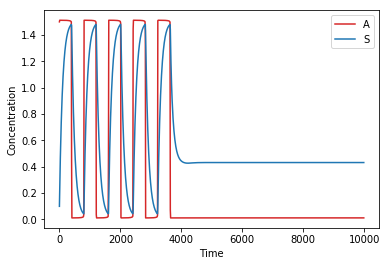

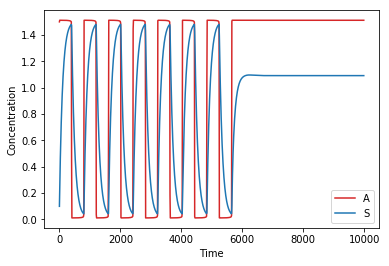

In [6]:
n_cells = 100

init_vec = 0.1*np.ones((n_cells, 2))
init_vec[:,0] = 1.5

# We induce boundary in first 5 cells
for i in range(5):
    init_vec[i,0]=0.1
    init_vec[i,1]=1.0

    
results, times_plot = integrate(init_vec, time_param, ode_param)

plot_all_kymographs(results)
plot_single_kymograph(results, 0)
plot_time_course(results, times_plot, 50)
plot_time_course(results, times_plot, 75)